# Springboard Apps project - Tier 3 - Modelling

Welcome to the final project of this Springboard prep course! To give you a taste of your future career, we're going to walk through exactly the kind of notebook that you'd write as a data scientist. In the process, we'll be sure to signpost the general framework for our investigation - the Data Science Pipeline - as well as give reasons for why we're doing what we're doing.

**Brief**

Did Apple Store apps receive better reviews than Google Play apps?

## Stages of the project

1. Sourcing and loading 
    * Load the two datasets
    * Pick the columns that we are going to work with 
    * Subsetting the data on this basis 
 
 
2. Cleaning, transforming and visualizing
    * Check the data types and fix them
    * Add a `platform` column to both the `Apple` and the `Google` dataframes
    * Changing the column names to prepare for a join 
    * Join the two data sets
    * Eliminate the `NaN` values
    * Filter only those apps that have been reviewed at least once
    * Summarize the data visually and analytically (by the column `platform`)  
  
  
3. Modelling 
    * Hypothesis formulation
    * Getting the distribution of the data
    * Permutation test 


4. Evaluating and concluding 
    * What is our conclusion?
    * What is our decision?
    * Other models we could have used. 
    

## Importing the libraries

In this case we are going to import pandas, numpy, scipy, random and matplotlib.pyplot

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
# scipi is a library for statistical tests and visualizations 
from scipy import stats
# random enables us to generate random numbers
import random

## Stage 1 -  Sourcing and loading data

### 1a. Source and load the data
Let's download the data from Kaggle. Kaggle is a fantastic resource: a kind of social medium for data scientists, it boasts projects, datasets and news on the freshest libraries and technologies all in one place. The data from the Apple Store can be found [here](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps) and the data from Google Store can be found [here](https://www.kaggle.com/lava18/google-play-store-apps).
Download the datasets and save them in your working directory.

In [2]:
# Now that the files are saved, we want to load them into Python using read_csv and pandas.

# Create a variable called google, and store in it the path of the csv file that contains your google dataset. 
# If your dataset is in the same folder as this notebook, the path will simply be the name of the file. 
google= "googleplaystore.csv"

# Read the csv file into a data frame called Google using the read_csv() pandas method.
Google=pd.read_csv(google)

# Using the head() pandas method, observe the first three entries.
Google.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


In [3]:
# Create a variable called apple, and store in it the path of the csv file that contains your apple dataset. 
apple="AppleStore.csv"

# Read the csv file into a pandas DataFrame object called Apple.
Apple=pd.read_csv(apple)
# Observe the first three entries like you did with your other data. 
Apple.head(3)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


### 1b. Pick the columns we'll work with

From the documentation of these datasets, we can infer that the most appropriate columns to answer the brief are:

1. Google:
    * `Category` # Do we need this?
    * `Rating`
    * `Reviews`
    * `Price` (maybe)
2. Apple:    
    * `prime_genre` # Do we need this?
    * `user_rating` 
    * `rating_count_tot`
    * `price` (maybe)

### 1c. Subsetting accordingly

Let's select only those columns that we want to work with from both datasets. We'll overwrite the subsets in the original variables.

In [4]:
# Subset our DataFrame object Google by selecting just the variables ['Category', 'Rating', 'Reviews', 'Price']
Google=Google[['Category',"Rating","Reviews",'Price']]
# Check the first three entries
Google.head(3)


,Category,Rating,Reviews,Price
0,ART_AND_DESIGN,4.1,159,0
1,ART_AND_DESIGN,3.9,967,0
2,ART_AND_DESIGN,4.7,87510,0


In [5]:
# Do the same with our Apple object, selecting just the variables ['prime_genre', 'user_rating', 'rating_count_tot', 'price']
Apple=Apple[['prime_genre', 'user_rating', 'rating_count_tot', 'price']]

# Let's check the first three entries
Apple.head(3) 

,prime_genre,user_rating,rating_count_tot,price
0,Games,4.0,21292,3.99
1,Productivity,4.0,161065,0.00
2,Weather,3.5,188583,0.00


## Stage 2 -  Cleaning, transforming and visualizing

### 2a. Check the data types for both Apple and Google, and fix them

Types are crucial for data science in Python. Let's determine whether the variables we selected in the previous section belong to the types they should do, or whether there are any errors here. 

In [6]:
# Using the dtypes feature of pandas DataFrame objects, check out the data types within our Apple dataframe.
# Are they what you expect?
Apple.dtypes

prime_genre          object
user_rating         float64
rating_count_tot      int64
price               float64
dtype: object

This is looking healthy. But what about our Google data frame?

In [7]:
# Using the same dtypes feature, check out the data types of our Google dataframe. 
Google.dtypes

Category     object
Rating      float64
Reviews      object
Price        object
dtype: object

Weird. The data type for the column 'Price' is 'object', not a numeric data type like a float or an integer. Let's investigate the unique values of this column. 

In [8]:
# Using the same dtypes feature, check out the data types of our Google dataframe. 
Google.dtypes

Category     object
Rating      float64
Reviews      object
Price        object
dtype: object

Aha! Fascinating. There are actually two issues here. 

- Firstly, there's a price called `Everyone`. That is a massive mistake! 
- Secondly, there are dollar symbols everywhere! 


Let's address the first issue first. Let's check the datapoints that have the price value `Everyone`

In [9]:
# Use the unique() pandas method on the Price column to check its unique values. 
Google["Price"].unique

<bound method Series.unique of 0        0
1        0
2        0
3        0
4        0
        ..
10836    0
10837    0
10838    0
10839    0
10840    0
Name: Price, Length: 10841, dtype: object>

Thankfully, it's just one row. We've gotta get rid of it. 

In [10]:
# Let's eliminate that row. 

# Subset our Google dataframe to pick out just those rows whose value for the 'Price' column is NOT 'Everyone'. 
# Reassign that subset to the Google variable. 
# You can do this in two lines or one. Your choice! 
Google.drop(Google[Google["Price"]=="Everyone"].index,inplace=True)
# Check again the unique values of Google
Google["Price"].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

Our second problem remains: I'm seeing dollar symbols when I close my eyes! (And not in a good way). 

This is a problem because Python actually considers these values strings. So we can't do mathematical and statistical operations on them until we've made them into numbers. 

In [11]:
# Let's create a variable called nosymb.
# This variable will take the Price column of Google and apply the str.replace() method. 
# Remember: we want to find '$' and replace it with nothing, so we'll have to write approrpiate arguments to the method to achieve this. 
nosymb= Google["Price"].str.replace("$","")
nosymb.head()

# Now we need to do two things:
# i. Make the values in the nosymb variable numeric using the to_numeric() pandas method.
# ii. Assign this new set of numeric, dollar-sign-less values to Google['Price']. 
# You can do this in one line if you wish.
Google["Price"]=pd.to_numeric(nosymb)

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


Now let's check the data types for our Google dataframe again, to verify that the 'Price' column really is numeric now.

In [12]:
# Use the function dtypes. 
Google.dtypes

Category     object
Rating      float64
Reviews      object
Price       float64
dtype: object

Notice that the column `Reviews` is still an object column. We actually need this column to be a numeric column, too. 

In [13]:
# Convert the 'Reviews' column to a numeric data type. 
# Use the method pd.to_numeric(), and save the result in the same column.
Google["Reviews"]=pd.to_numeric(Google["Reviews"])

In [14]:
# Let's check the data types of Google again
Google.dtypes

Category     object
Rating      float64
Reviews       int64
Price       float64
dtype: object

### 2b. Add a `platform` column to both the `Apple` and the `Google` dataframes
Let's add a new column to both dataframe objects called `platform`: all of its values in the Google dataframe will be just 'google', and all of its values for the Apple dataframe will be just 'apple'. 

The reason we're making this column is so that we can ultimately join our Apple and Google data together, and actually test out some hypotheses to solve the problem in our brief. 

In [15]:
# Create a column called 'platform' in both the Apple and Google dataframes. 
# Add the value 'apple' and the value 'google' as appropriate. 
Apple['platform'] = "apple"
Google['platform']= "google"

### 2c. Changing the column names to prepare for our join of the two datasets 
Since the easiest way to join two datasets is if they have both:
- the same number of columns
- the same column names
we need to rename the columns of `Apple` so that they're the same as the ones of `Google`, or vice versa.

In this case, we're going to change the `Apple` columns names to the names of the `Google` columns. 

This is an important step to unify the two datasets!

In [16]:
# Create a variable called old_names where you'll store the column names of the Apple dataframe. 
# Use the feature .columns.
old_names =Apple.columns

# Create a variable called new_names where you'll store the column names of the Google dataframe. 
new_names=Google.columns

# Use the rename() DataFrame method to change the columns names. 
# In the columns parameter of the rename() method, use this construction: dict(zip(old_names,new_names)).
Apple = Apple.rename(columns =dict(zip(old_names,new_names)))


### 2d. Join the two datasets 
Let's combine the two datasets into a single data frame called `df`.

In [17]:
# Let's use the append() method to append Apple to Google. 
# Make Apple the first parameter of append(), and make the second parameter just: ignore_index = True.
df = Google.append(Apple,ignore_index= True)

# Using the sample() method with the number 12 passed to it, check 12 random points of your dataset.
df.sample(12)

,Category,Rating,Reviews,Price,platform
17924,Entertainment,4.5,11,0.99,apple
9120,FINANCE,4.0,26,0.00,google
5782,GAME,4.2,3845,0.00,google
9725,FAMILY,3.9,249,0.00,google
1512,HOUSE_AND_HOME,4.6,353813,0.00,google
17697,Games,0.0,0,1.99,apple
6279,FAMILY,4.9,7,0.00,google
9883,FAMILY,3.8,4,0.00,google
11387,Shopping,4.5,15593,0.00,apple
13158,Productivity,4.5,6288,14.99,apple


### 2e. Eliminate the NaN values

As you can see there are some `NaN` values. We want to eliminate all these `NaN` values from the table.

In [18]:
# Lets check first the dimesions of df before droping `NaN` values. Use the .shape feature. 
df.shape
# Use the dropna() method to eliminate all the NaN values, and overwrite the same dataframe with the result. 
# Note: dropna() by default removes all rows containing at least one NaN. 
df.dropna()
#
# Check the new dimesions of our dataframe. 
df.shape
df.dtypes

Category     object
Rating      float64
Reviews       int64
Price       float64
platform     object
dtype: object

### 2f. Filter the data so that we only see whose apps that have been reviewed at least once

Apps that haven't been reviewed yet can't help us solve our brief. 

So let's check to see if any apps have no reviews at all. 

In [19]:
# Subset your df to pick out just those rows whose value for 'Reviews' is equal to 0. 
# Do a count() on the result. 
df[df["Reviews"] == 0].count()

Category    1525
Rating       929
Reviews     1525
Price       1525
platform    1525
dtype: int64

929 apps do not have reviews, we need to eliminate these points!

In [20]:
# Eliminate the points that have 0 reviews.
# An elegant way to do this is to assign df the result of picking out just those rows in df whose value for 'Reviews' is NOT 0.
df =df[df["Reviews"]!=0]
df.head()

,Category,Rating,Reviews,Price,platform
0,ART_AND_DESIGN,4.1,159,0.0,google
1,ART_AND_DESIGN,3.9,967,0.0,google
2,ART_AND_DESIGN,4.7,87510,0.0,google
3,ART_AND_DESIGN,4.5,215644,0.0,google
4,ART_AND_DESIGN,4.3,967,0.0,google


### 2g. Summarize the data visually and analytically (by the column `platform`)

What we need to solve our brief is a summary of the `Rating` column, but separated by the different platforms.

In [21]:
# To summarize analytically, let's use the groupby() method on our df.
# For its parameters, let's assign its 'by' parameter 'platform', and then make sure we're seeing 'Rating' too. 
# Finally, call describe() on the result. We can do this in one line, but this isn't necessary. 
df.groupby("platform").describe()

Rating                                               Reviews  \
           count      mean       std  min  25%  50%  75%  max    count   
platform                                                                 
apple     6268.0  4.049697  0.726943  1.0  4.0  4.5  4.5  5.0   6268.0   
google    9366.0  4.191757  0.515219  1.0  4.0  4.3  4.5  5.0  10244.0   

                         ...                         Price            \
                   mean  ...      75%         max    count      mean   
platform                 ...                                           
apple      14803.805520  ...   3963.5   2974676.0   6268.0  1.821977   
google    469993.888422  ...  63767.0  78158306.0  10244.0  0.931450   

                                                  
                std  min  25%  50%   75%     max  
platform                                          
apple      6.128238  0.0  0.0  0.0  2.99  299.99  
google    15.186260  0.0  0.0  0.0  0.00  400.00  

[2 rows x 24 columns]

Interesting! Our means of 4.049697 and 4.191757 don't **seem** all that different! Perhaps we've solved our brief already: there's no significant difference between Google Play app reviews and Apple Store app reviews. We have an ***observed difference*** here: which is simply (4.191757 - 4.049697) = 0.14206. This is just the actual difference that we observed between the mean rating for apps from Google Play, and the mean rating for apps from the Apple Store. Let's look at how we're going to use this observed difference to solve our problem using a statistical test. 

**Outline of our method:**
1. We'll assume that platform (i.e, whether the app was Google or Apple) really doesn’t impact on ratings. 


2. Given this assumption, we should actually be able to get a difference in mean rating for Apple apps and mean rating for Google apps that's pretty similar to the one we actually got (0.14206) just by: 
a. shuffling the ratings column, 
b. keeping the platform column the same,
c. calculating the difference between the mean rating for Apple and the mean rating for Google. 


3. We can make the shuffle more useful by doing it many times, each time calculating the mean rating for Apple apps and the mean rating for Google apps, and the difference between these means. 


4. We can then take the mean of all these differences, and this will be called our permutation difference. This permutation difference will be great indicator of what the difference would be if our initial assumption were true and platform really doesn’t impact on ratings. 


5. Now we do a comparison. If the observed difference looks just like the permutation difference, then we stick with the claim that actually, platform doesn’t impact on ratings. If instead, however, the permutation difference differs significantly from the observed difference, we'll conclude: something's going on; the platform does in fact impact on ratings. 


6. As for what the definition of *significantly* is, we'll get to that. But there’s a brief summary of what we're going to do. Exciting!

If you want to look more deeply at the statistics behind this project, check out [this resource](https://www.springboard.com/archeio/download/4ea4d453b0b84014bcef287c50f47f00/).

Let's also get a **visual summary** of the `Rating` column, separated by the different platforms. 

A good tool to use here is the boxplot!

<AxesSubplot:title={'center':'Rating'}, xlabel='platform'>

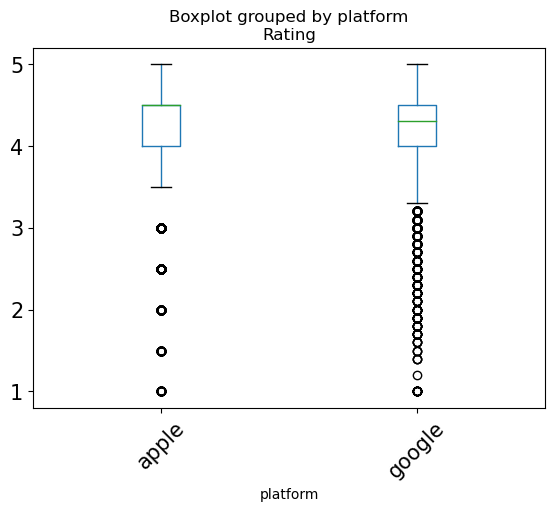

In [22]:
# Call the boxplot() method on our df.
# Set the parameters: by = 'platform' and column = ['Rating'].
df.boxplot(by='platform', column ='Rating', grid=False, rot=45, fontsize=15)


Here we see the same information as in the analytical summary, but with a boxplot. Can you see how the boxplot is working here? If you need to revise your boxplots, check out this this [link](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps). 

## Stage 3 - Modelling

### 3a. Hypothesis formulation

Our **Null hypothesis** is just:

**H<sub>null</sub>**: the observed difference in the mean rating of Apple Store and Google Play apps is due to chance (and thus not due to the platform).

The more interesting hypothesis is called the **Alternate hypothesis**:

**H<sub>alternative</sub>**: the observed difference in the average ratings of apple and google users is not due to chance (and is actually due to platform)

We're also going to pick a **significance level** of 0.05. 

### 3b. Getting the distribution of the data
Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept. 

There are many different statistical tests, all with different assumptions. You'll generate an excellent judgement about when to use which statistical tests over the Data Science Career Track course. But in general, one of the most important things to determine is the **distribution of the data**.   

In [23]:
# Create a subset of the column 'Rating' by the different platforms.
# Call the subsets 'apple' and 'google' 
apple = df[df['platform'] == 'apple']['Rating']
google = df[df['platform']== 'google']["Rating"]
google.head()

0    4.1
1    3.9
2    4.7
3    4.5
4    4.3
Name: Rating, dtype: float64

In [24]:
# Using the stats.normaltest() method, get an indication of whether the apple data are normally distributed
# Save the result in a variable called apple_normal, and print it out
# Since the null hypothesis of the normaltest() is that the data is normally distributed, the lower the p-value in the result of this test, the more likely the data are to be normally distributed.
apple_normal = stats.normaltest(apple)
print(apple_normal)


NormaltestResult(statistic=1778.9974234584017, pvalue=0.0)


In [25]:
# Do the same with the google data. 
# Save the result in a variable called google_normal
google.head()
google_normal=stats.normaltest(google)
print(google_normal)

NormaltestResult(statistic=nan, pvalue=nan)


Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal. 

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed. 

We can actually also check out the distribution of the data visually with a histogram. A normal distribution has the following visual characteristics:
    - symmetric
    - unimodal (one hump)
As well as a roughly identical mean, median and mode. 

Text(0.5, 0, 'Apple rating')

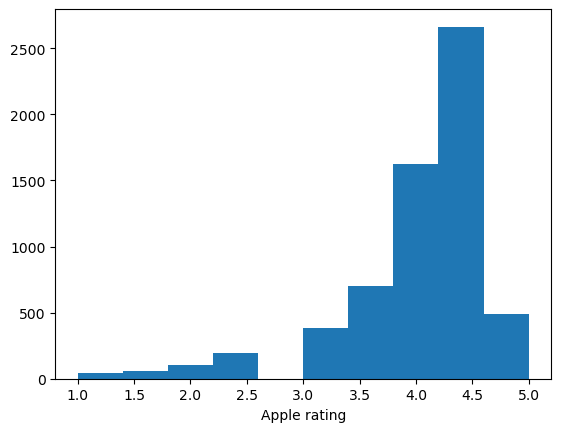

In [47]:
# Create a histogram of the apple reviews distribution
# You'll use the plt.hist() method here, and pass your apple data to it
#histoApple = plt.hist(_ _ _)
import matplotlib.pyplot as plt
histoApple=plt.hist(apple)
plt.xlabel("Apple rating")

Text(0.5, 0, 'Google Play rating')

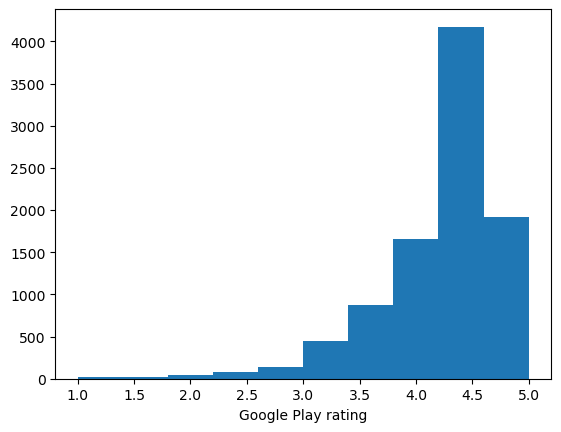

In [48]:
# Create a histogram of the google data
histoGoogle =plt.hist(google)
plt.xlabel("Google Play rating")

### 3c. Permutation test
Since the data aren't normally distributed, we're using a *non-parametric* test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.  

Check out more about permutations [here.](http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/)

In [28]:
# Create a column called `Permutation1`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation1'] = np.random.permutation(df["Rating"])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby(by='platform')['Permutation1'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
apple,5939.0,4.142095,0.610533,1.0,4.0,4.3,4.5,5.0
google,9695.0,4.130335,0.614419,1.0,4.0,4.3,4.5,5.0


In [29]:
# Lets compare with the previous analytical summary:
df.groupby(by='platform')['Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
apple,6268.0,4.049697,0.726943,1.0,4.0,4.5,4.5,5.0
google,9366.0,4.191757,0.515219,1.0,4.0,4.3,4.5,5.0


In [44]:
# The difference in the means for Permutation1 (0.001103) now looks hugely different to our observed difference of 0.14206. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; platform does impact on ratings
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for Google and Apple apps and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.

# First, make a list called difference.
difference=[]

# Now make a for loop that does the following 10,000 times:
# 1. makes a permutation of the 'Rating' as you did above
# 2. calculates the difference in the mean rating for apple and the mean rating for google. 
'''
for i in range(1,1):
    permutation = np.random.permutation(df["Rating"])
    difference.append(np.mean(permutation[df['platform']=='apple']) - np.mean(permutation[df['platform']=='google']))
'''

for i in range(1,10000):
    df['permutation'] = np.random.permutation(df["Rating"])
    difference.append(np.mean(df[df['platform']=='apple']['permutation']) - np.mean(df[df['platform']=='google']['permutation']))
    
#print(type(permutation))
#print("diff",difference)


Text(0.5, 0, ' Difference in the means for 10,000 permuations')

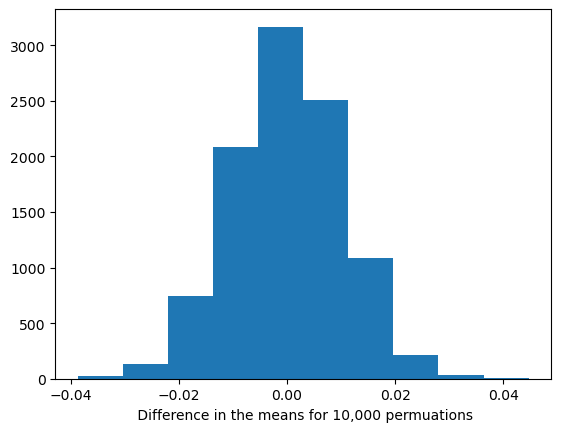

In [50]:
# Make a variable called 'histo', and assign to it the result of plotting a histogram of the difference list. 
histo=plt.hist(difference)
#print(difference)
plt.xlabel(" Difference in the means for 10,000 permuations")

In [46]:
# Now make a variable called obs_difference, and assign it the result of the mean of our 'apple' variable and the mean of our 'google variable'
obs_difference= np.mean(apple) - np.mean(google)

# Make this difference absolute with the built-in abs() function. 
obs_difference = abs(obs_difference)

# Print out this value; it should be 0.1420605474512291. 
print(obs_difference)

0.14206054745123442
